# Neuropixel data loading and quality metrics

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import aopy
import os
import pandas as pds
from db import dbfunctions as db

/home/aolab/miniconda3/envs/ryan-analysis/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


In [3]:
# Define data to load
subject = 'affi'
preproc_dir = '/media/moor-data/preprocessed.new/'
te_id = 18199
drive = 1 # If multiple probes were used in the recording this defines which one to load data from.

# Define parameters
bin_width = 0.01
tbefore = 0.2
tafter = 0.5

## Load preprocessed neuropixel data

There are many types of neuropixel data, both raw and preprocessed. Here is a brief summary:
- **Raw AP-band data:** This is the timeseries data directly saved from the Neuropixels experiment. It has been hardware filtered with a 300-10,000Hz bandpass filter. The sampling rate is 30,000Hz.
- **Raw LFP-band data:** This is the timeseries data directly saved from the Neuropixels experiment. It has been hardware filtered with a 0.5-500Hz bandpass filter. The sampling rate is defined by 'lfp_samplerate'. The sampling rate is 2500Hz
- **Spike Times:** The resulting spike times after the raw AP-band data has been spike sorted.
- **Preprocessed AP data:** Preprocessed AP-band timeseries data that has been downsampled to 10,000Hz. This sampling rate is defined by 'ap_samplerate'
- **Preprocessed LFP data:** Preprocessed LFP-band timeseries data that has been downsampled to 1,000Hz. This sampling rate is defined by 'lfp_samplerate'

In [4]:
# Load and tabulate Behavioral data
entry = db.get_task_entries(id=te_id)[0]
date = entry.date.date()
_, exp_metadata = aopy.data.load_preproc_exp_data(preproc_dir, subject, te_id, date)
samplerate = exp_metadata['cursor_interp_samplerate'] # Sample rate of behavioral data

df = aopy.data.bmi3d.tabulate_behavior_data_center_out(preproc_dir, [subject], [te_id], [date], metadata=['target_radius', 'neuropixel_port1_site', 'neuropixel_port2_site'])

  0%|          | 0/1 [00:00<?, ?it/s]

What `spike_times` contains:
dtype: <class 'dict'>
First 5 key examples: ['0', '1', '2', '3', '4']
First dictionary entry size [nspikes]: (22077,)
First 5 spike times of the first dictionary entry [s]: [0.20516956 0.30140164 0.41840012 0.62713073 1.6402842 ]


What `waveforms` contains:
dtype: <class 'dict'>
First 5 key examples: ['0', '1', '2', '3', '4']
First dictionary entry size [nspikes, ntime, nch]: (22077, 60, 1)


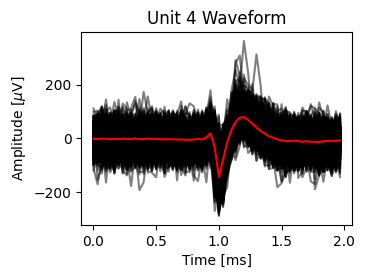

In [5]:
# Example load_preproc functions in aopy to load preprocessed neuropixel spiking data
spike_times, spike_metadata = aopy.data.base.load_preproc_spike_data(preproc_dir, subject, te_id, date, drive)
waveforms = aopy.data.base.load_spike_waveforms(preproc_dir, subject, te_id, date, drive)

print('\033[1mWhat `spike_times` contains:\033[0m')
print(f"dtype: {type(spike_times)}")
print(f"First 5 key examples: {list(spike_times.keys())[:5]}")
print(f"First dictionary entry size [nspikes]: {spike_times['0'].shape}")
print(f"First 5 spike times of the first dictionary entry [s]: {spike_times['0'][:5]}")
print('\n')
print('\033[1mWhat `waveforms` contains:\033[0m')
print(f"dtype: {type(spike_times)}")
print(f"First 5 key examples: {list(waveforms.keys())[:5]}")
print(f"First dictionary entry size [nspikes, ntime, nch]: {waveforms['0'].shape}") # The preprocessed waveforms will always only include the channel that recorded the highest amplitude waveform.
unit_label = '4'
fig, ax = plt.subplots(1,1, figsize=(3.5,2.5))
time_axis = 1e3*np.arange(waveforms[unit_label].shape[1])/spike_metadata['samplerate']
ax.plot(time_axis, (spike_metadata['microvoltsperbit'][0]*np.mean(waveforms[unit_label], axis=(2))).T, 'k', alpha=0.5)
ax.plot(time_axis, spike_metadata['microvoltsperbit'][0]*np.mean(waveforms[unit_label], axis=(0,2)), 'r')
ax.set(xlabel='Time [ms]', ylabel='Amplitude [$\mu$V]', title=f'Unit {unit_label} Waveform')
plt.show()

What `ap_data` contains:
dtype: <class 'numpy.ndarray'>
ap_data size [ntime, nch]: (11369471, 384)
ap_data samplerate: 10000.130272980834


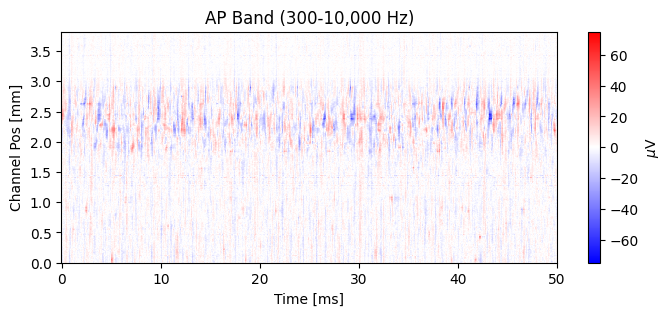

In [22]:
# Example load_preproc functions in aopy to load preprocessed ap band data
ap_data, ap_metadata = aopy.data.base.load_preproc_ap_data(preproc_dir, subject, te_id, date, drive) 

print('\033[1mWhat `ap_data` contains:\033[0m')
print(f"dtype: {type(ap_data)}")
print(f"ap_data size [ntime, nch]: {ap_data.shape}")
print(f"ap_data samplerate: {ap_metadata['ap_samplerate']}")
start_time, ntime_plot = 1, 0.05 # [s] start of data and length of data to plot
start_idx = int(start_time*ap_metadata['ap_samplerate'])
nch = ap_data.shape[1]
fig, ax = plt.subplots(1,1, figsize=(8,3))
time_axis = 1e3*np.arange(ntime_plot*ap_metadata['ap_samplerate'])/ap_metadata['ap_samplerate']
im = ax.pcolor(time_axis, ap_metadata['ypos']/1E3, ap_metadata['microvoltsperbit'][0]*ap_data[start_idx:(start_idx+len(time_axis)),:].T, cmap='bwr', vmin=-75, vmax=75)
cb = plt.colorbar(im, label='$\mu$V')
ax.set(xlabel='Time [ms]', ylabel='Channel Pos [mm]', title='AP Band (300-10,000 Hz)') # The electrode at position 0 is at the bottom of the probe
plt.show()

What `lfp_data` contains:
dtype: <class 'numpy.ndarray'>
lfp_data size [ntime, nch]: (1136948, 384)
lfp_data samplerate: 1000.0129968682988


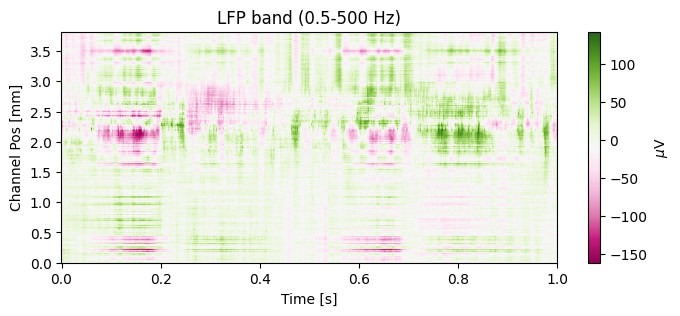

In [25]:
# Load continuous LFP data
lfp_data, lfp_metadata = aopy.data.base.load_preproc_lfp_data(preproc_dir, subject, te_id, date, drive) 

print('\033[1mWhat `lfp_data` contains:\033[0m')
print(f"dtype: {type(lfp_data)}")
print(f"lfp_data size [ntime, nch]: {lfp_data.shape}")
print(f"lfp_data samplerate: {lfp_metadata['lfp_samplerate']}")
start_time, ntime_plot = 1, 1 # [s] start of data and length of data to plot
start_idx = int(start_time*lfp_metadata['lfp_samplerate'])
nch = lfp_data.shape[1]
fig, ax = plt.subplots(1,1, figsize=(8,3))
time_axis = np.arange(ntime_plot*lfp_metadata['lfp_samplerate'])/lfp_metadata['lfp_samplerate']
im = ax.pcolor(time_axis, ap_metadata['ypos']/1E3, lfp_metadata['microvoltsperbit'][0]*lfp_data[start_idx:(start_idx+len(time_axis)),:].T, cmap='PiYG')
cb = plt.colorbar(im, label='$\mu$V')
ax.set(xlabel='Time [s]', ylabel='Channel Pos [mm]', title='LFP band (0.5-500 Hz)') # The electrode at position 0 is at the bottom of the probe
plt.show()

## Tabulate neuropixel data

In [7]:
# Prepare lists for tabulation
subjects = [subject for itrial in range(np.sum(df['reward']))] # Need one for each trial that is loaded
te_ids = [te_id for itrial in range(np.sum(df['reward']))] # Need one for each trial that is loaded
dates = [date for itrial in range(np.sum(df['reward']))] # Need one for each trial that is loaded
drives = [drive for itrial in range(np.sum(df['reward']))] # Need one for each trial that is loaded
start_times = list(df['go_cue_time'][df['reward']])
end_times = list(df['reach_end_time'][df['reward']])

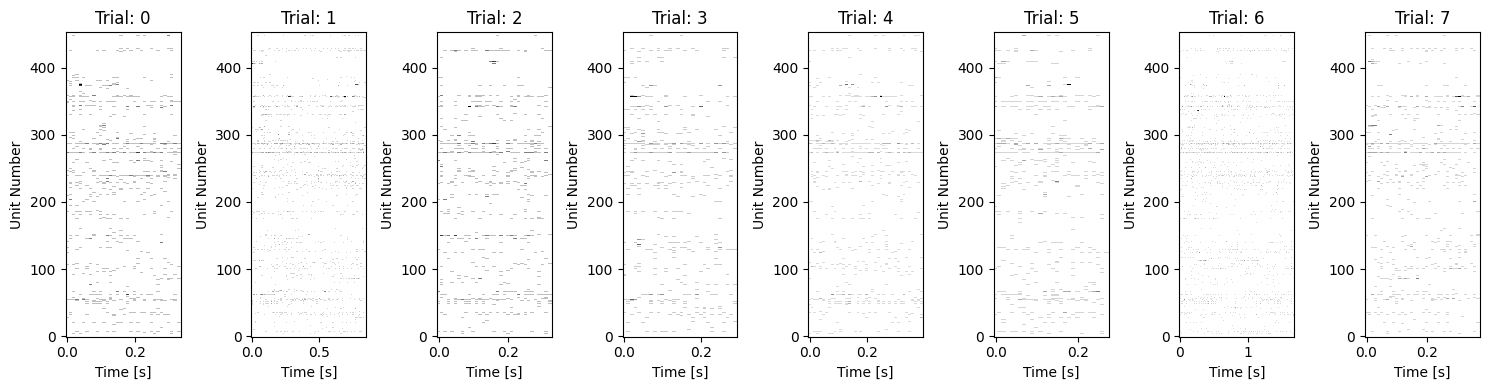

In [8]:
# Tabulate spiking data segments - only load rewarded trials
spike_segments, _ = aopy.data.bmi3d.tabulate_spike_data_segments(preproc_dir, subjects, te_ids, dates, start_times=start_times, end_times=end_times, drives=drives, bin_width=bin_width)

# Plot spiking activity raster for all units for the first few trials
ntrials_plot = 8
fig, ax = plt.subplots(1,ntrials_plot,figsize=(15,4))
for iax in range(len(ax)):
    segment_raster = []
    for unit in list(spike_segments[iax].keys()):
        segment_raster.append(spike_segments[iax][unit])
    trial_time_axis = np.arange(np.array(segment_raster).shape[1])*bin_width
    unit_axis =  np.arange(np.array(segment_raster).shape[0])
    ax[iax].pcolor(trial_time_axis, unit_axis, np.array(segment_raster), cmap='gray_r')
    ax[iax].set(xlabel='Time [s]', ylabel='Unit Number', title=f"Trial: {iax}")

fig.tight_layout()
plt.show()

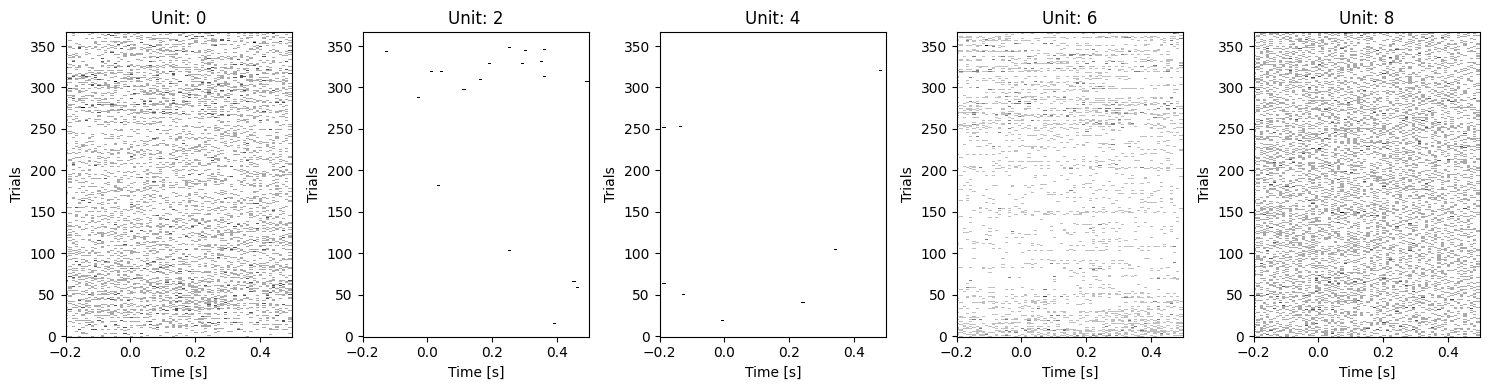

In [9]:
# Tabulate spike data rasters
spike_aligned, unit_labels, raster_bins = aopy.data.bmi3d.get_spike_data_aligned(preproc_dir, subject, te_id,date, np.array(start_times), tbefore, tafter, drive, bin_width=0.01) # Spike times must be input as an array right now.

# Plot example rasters
units_to_plot = 5
fig, ax = plt.subplots(1,units_to_plot,figsize=(15,4))

for iax in range(len(ax)):
    ax[iax].pcolor(raster_bins, np.arange(len(start_times)), spike_aligned[:,iax*2,:].T, cmap='gray_r')
    ax[iax].set(xlabel='Time [s]', ylabel='Trials', title=f"Unit: {unit_labels[iax*2]}")

fig.tight_layout()
plt.show()

## Apply unit quality metrics

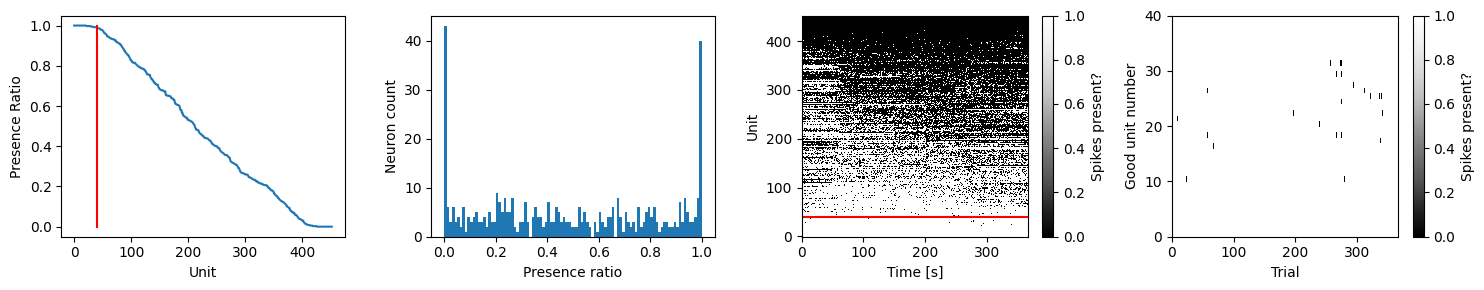

In [10]:
# Apply presence ratio and plot results
presence_ratio, present_units, presence_details = aopy.postproc.neuropixel.calc_presence_ratio(spike_aligned, min_trial_prop=0.99, return_details=True)

fig, ax = plt.subplots(1,4,figsize=(15,3))
ax[0].plot(presence_ratio[np.flip(np.argsort(presence_ratio))])
ax[0].plot([np.sum(present_units), np.sum(present_units)], [0,1], 'r', label='Neuron cutoff')
ax[0].set(xlabel='Unit', ylabel='Presence Ratio')

ax[1].hist(presence_ratio, bins=100)
ax[1].set(xlabel='Presence ratio', ylabel='Neuron count')

pdetails_im = ax[2].pcolor(np.arange(presence_details.shape[1]), np.arange(presence_details.shape[0]), presence_details[np.flip(np.argsort(presence_ratio)),:],cmap='Greys_r', vmin=0, vmax=1)
ax[2].plot([0, presence_details.shape[1]], [np.sum(present_units), np.sum(present_units)], 'r', label='Neuron cutoff')
ax[2].set(xlabel='Time [s]', ylabel='Unit', xlim=[0, presence_details.shape[1]])
cb = plt.colorbar(pdetails_im, label='Spikes present?')
            
pdetails_im = ax[3].pcolor(presence_details[present_units,:],cmap='Greys_r', vmin=0, vmax=1)
ax[3].set(xlabel='Trial', ylabel='Good unit number')
cb = plt.colorbar(pdetails_im, label='Spikes present?')
    
fig.tight_layout()
plt.show()

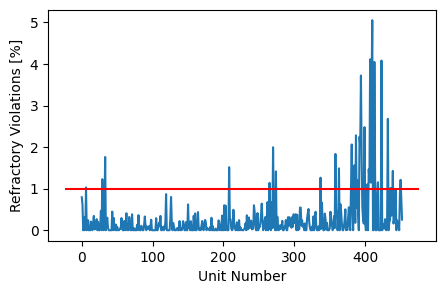

In [11]:
# Apply refractory period violation check 
spike_times, _ = aopy.data.base.load_preproc_spike_data(preproc_dir, subject, te_id, date, drive)

min_ref_period = 1 #[ms]
ref_perc_thresh = 1 #[%]
ref_good_unit_labels, ref_violation = aopy.postproc.neuropixel.get_units_without_refractory_violations(spike_times, ref_perc_thresh=ref_perc_thresh, min_ref_period=min_ref_period)

fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.plot(np.arange(len(unit_labels)), ref_violation)
ax.plot(ax.get_xlim(), [min_ref_period,min_ref_period], 'r')
ax.set(xlabel='Unit Number', ylabel='Refractory Violations [%]')
plt.show()

In [12]:
# Apply amplitude cutoff
waveform_amplitude_threshold = 50
amp_good_unit_labels, amplitudes, mean_waveforms = aopy.postproc.neuropixel.get_high_amplitude_units(preproc_dir, subject, te_id, date, drive, waveform_amplitude_threshold, include_bad_unit_wfs=True)

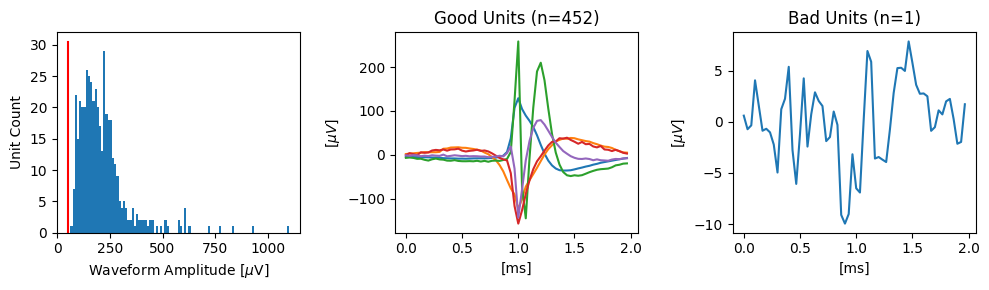

In [13]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
ax[0].hist(amplitudes, bins=100)
ax[0].set(xlabel='Waveform Amplitude [$\mu$V]', ylabel='Unit Count')
ax[0].plot([waveform_amplitude_threshold, waveform_amplitude_threshold], ax[0].get_ylim(), 'r')

nwf_plot = 5
good_unit_idx = np.isin(unit_labels, amp_good_unit_labels)
wf_samplerate = aopy.data.base.load_preproc_spike_data(preproc_dir, subject, te_id, date, drive)[1]['ap_samplerate']
wf_time_axis = 1e3*np.arange(mean_waveforms.shape[0])/wf_samplerate
ax[1].plot(wf_time_axis, mean_waveforms[:,good_unit_idx][:,:nwf_plot])
ax[1].set(xlabel='[ms]', ylabel='[$\mu V$]', title=f'Good Units (n={np.sum(good_unit_idx)})')

ax[2].plot(wf_time_axis, mean_waveforms[:,~good_unit_idx][:,:nwf_plot])
ax[2].set(xlabel='[ms]', ylabel='[$\mu V$]', title=f'Bad Units (n={np.sum(~good_unit_idx)})') # if units aren't shown it is likely becasue there weren't 
fig.tight_layout()
plt.show()

In [14]:
# Apply kilosort noise cutoff threshold
template_amplitudes = aopy.postproc.neuropixel.extract_ks_template_amplitudes(preproc_dir, subject, te_id, date, drive, data_source='Neuropixel', start_time=0, end_time=None) # Load template amplitudes from preprocessed kilosort folder. TODO replace with extracting amplitudes directly from preprocessed data once Tomo puts them in.
ksamp_good_unit_labels, low_bin_perc, cutoff_metric = aopy.postproc.neuropixel.apply_noise_cutoff_thresh(template_amplitudes, bin_width=0.2, low_bin_thresh=0.1, uhq_std_thresh=5, min_spikes=10)

18199


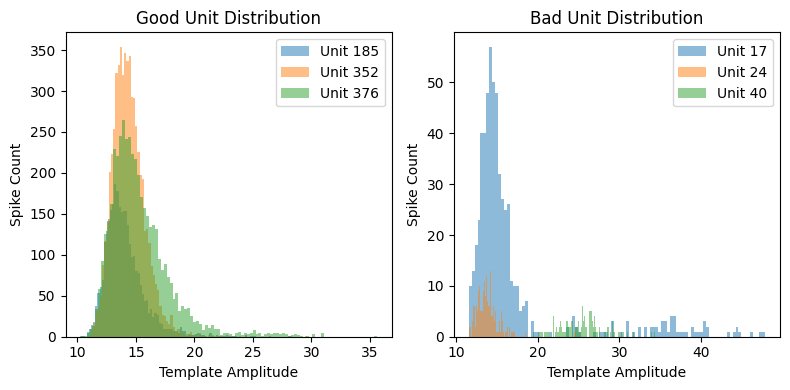

In [15]:
# Plot an example of a few units determined to be good and bad
nunits_plot = 3
fig, ax = plt.subplots(1,2,figsize=(8,4))
bad_unit_labels = np.array(unit_labels)[~np.isin(unit_labels, ksamp_good_unit_labels)]
for iunit in range(nunits_plot):
    ax[0].hist(template_amplitudes[ksamp_good_unit_labels[iunit]], bins=100, alpha=0.5)
    ax[1].hist(template_amplitudes[bad_unit_labels[iunit]], bins=100, alpha=0.5)

ax[0].legend([f'Unit {ksamp_good_unit_labels[0]}', f'Unit {ksamp_good_unit_labels[1]}', f'Unit {ksamp_good_unit_labels[2]}'])
ax[1].legend([f'Unit {bad_unit_labels[0]}', f'Unit {bad_unit_labels[1]}', f'Unit {bad_unit_labels[2]}'])
ax[0].set(xlabel='Template Amplitude', ylabel='Spike Count', title='Good Unit Distribution')
ax[1].set(xlabel='Template Amplitude', ylabel='Spike Count', title='Bad Unit Distribution')
fig.tight_layout()
plt.show()

## Apply all unit quality metrics

In [16]:
# Combine unit quality metrics to estimate good units
present_unit_mask = present_units
ref_good_unit_mask = np.in1d(np.array(unit_labels), ref_good_unit_labels)
amp_good_unit_mask = np.in1d(np.array(unit_labels), amp_good_unit_labels)
ksamp_good_unit_mask = np.in1d(np.array(unit_labels), ksamp_good_unit_labels)

final_good_unit_mask = present_unit_mask*ref_good_unit_mask*amp_good_unit_mask*ksamp_good_unit_mask

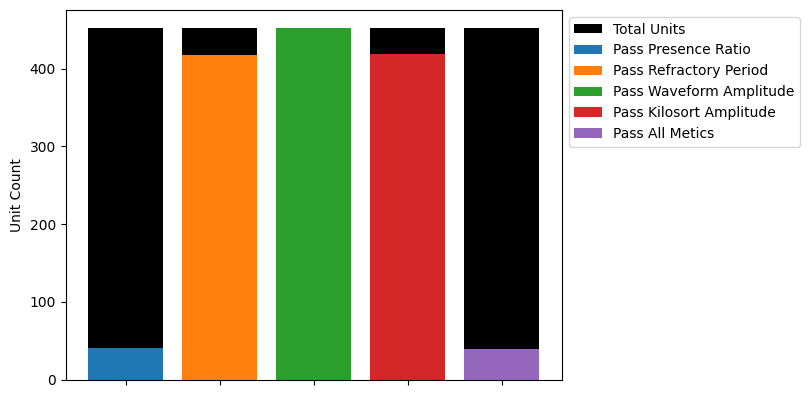

In [17]:
# Plot how many units are removed by each metric
fig, ax = plt.subplots(1,1)
[ax.bar(np.arange(5), [len(unit_labels), len(unit_labels), len(unit_labels), len(unit_labels), len(unit_labels)], color='black', label='Total Units')]
ax.bar(0, np.sum(present_unit_mask),  label='Pass Presence Ratio')
ax.bar(1, np.sum(ref_good_unit_mask), label='Pass Refractory Period')
ax.bar(2, np.sum(amp_good_unit_mask), label='Pass Waveform Amplitude')
ax.bar(3, np.sum(ksamp_good_unit_mask), label='Pass Kilosort Amplitude')
ax.bar(4, np.sum(final_good_unit_mask), label='Pass All Metics')
ax.legend(bbox_to_anchor=(1,1))
ax.set(ylabel='Unit Count')
ax.set_xticks(np.arange(5), [])
plt.show()

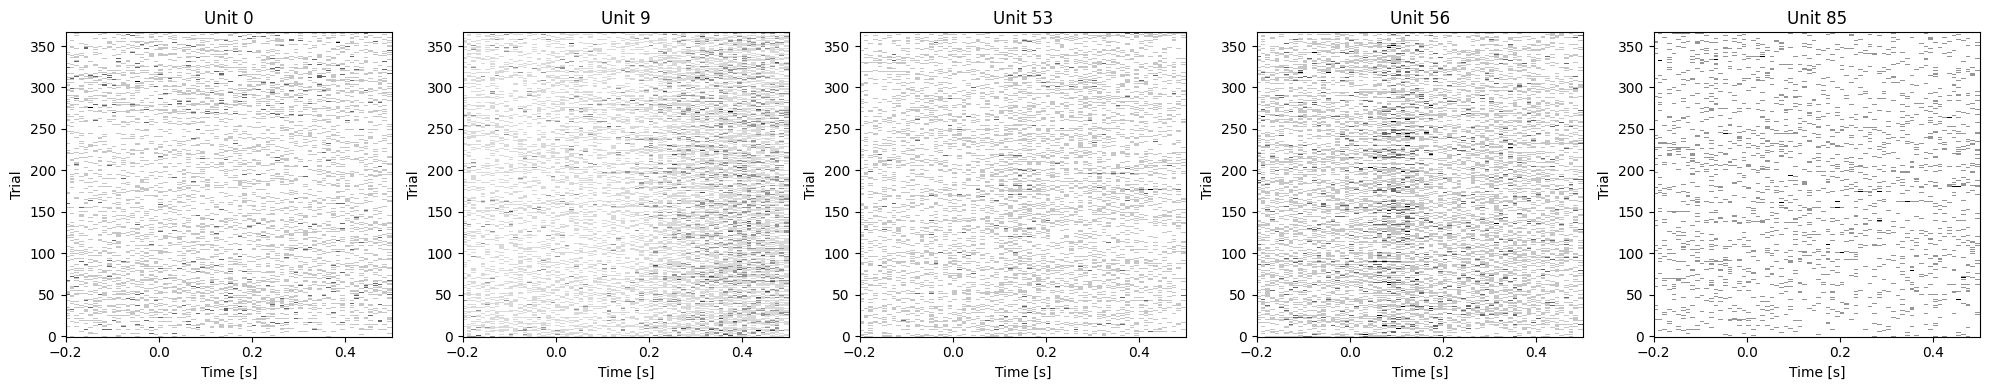

In [18]:
# Plot some rasters of units that pass all quality metrics
nrasters = 5
fig, ax = plt.subplots(1,nrasters,figsize=(nrasters*4, 4))
for iunit in range(nrasters):
    plt_unit_idx = np.where(final_good_unit_mask)[0][iunit*2]
    ax[iunit].pcolor(raster_bins, np.arange(len(start_times)), spike_aligned[:,plt_unit_idx,:].T, cmap='Grays')
    ax[iunit].set(xlabel='Time [s]', ylabel='Trial', title=f"Unit {unit_labels[plt_unit_idx]}")

fig.tight_layout()
plt.show()